In [16]:
import pandas as pd
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

warnings.filterwarnings("ignore")

In [5]:
# Use this chunk to generate the dataset if not already created
# df = pd.DataFrame()
# files = os.listdir("./data/patients_new")
# for file in files:
    # patient = pd.read_json(os.path.join("./data/patients_new/", file))
    # df = pd.concat([df, patient], ignore_index=True)
# df.reset_index(drop=True)
# df.to_csv("./collated_dataset.csv", index=False)

df = pd.read_csv("./collated_dataset.csv")

In [6]:
# Normalize admit and discharge times, and calculate duration of stay
df = df.sort_values(by=["admittime"]).reset_index(drop=True)
df['admittime'] = df['admittime'].apply(lambda x: pd.to_datetime(x).replace(year=2024))
df['dischtime'] = df['dischtime'].apply(lambda x: pd.to_datetime(x).replace(year=2024))
df['dischtime'] = df.apply(lambda row: pd.to_datetime(row['dischtime']).replace(year=2025) if row['dischtime'].month < row['admittime'].month else row['dischtime'], axis=1)
df["duration_of_stay"] = pd.to_datetime(df["dischtime"]) - pd.to_datetime(df["admittime"])
df

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,labevents,microbiologyevents,pharmacy,poe,prescriptions,procedures_icd,services,transfers,icustays,duration_of_stay
0,10001725,25563031,2024-04-11 15:08:00,2024-04-14 15:00:00,NaN,EW EMER.,P35SU0,PACU,HOME,Other,...,"[{'labevent_id': 12708, 'subject_id': 10001725...","[{'microevent_id': 558, 'subject_id': 10001725...","[{'subject_id': 10001725, 'hadm_id': 25563031,...","[{'poe_id': '10001725-48', 'poe_seq': 48, 'sub...","[{'subject_id': 10001725, 'hadm_id': 25563031,...","[{'subject_id': 10001725, 'hadm_id': 25563031,...","[{'subject_id': 10001725, 'hadm_id': 25563031,...","[{'subject_id': 10001725, 'hadm_id': 25563031....","[{'subject_id': 10001725, 'hadm_id': 25563031,...",2 days 23:52:00
1,10008454,20291550,2024-11-30 06:31:00,2024-12-10 15:53:00,NaN,EW EMER.,P77BSD,EMERGENCY ROOM,HOME HEALTH CARE,Other,...,"[{'labevent_id': 102608, 'subject_id': 1000845...","[{'microevent_id': 3030, 'subject_id': 1000845...","[{'subject_id': 10008454, 'hadm_id': 20291550,...","[{'poe_id': '10008454-137', 'poe_seq': 137, 's...","[{'subject_id': 10008454, 'hadm_id': 20291550,...","[{'subject_id': 10008454, 'hadm_id': 20291550,...","[{'subject_id': 10008454, 'hadm_id': 20291550,...","[{'subject_id': 10008454, 'hadm_id': 20291550....","[{'subject_id': 10008454, 'hadm_id': 20291550,...",10 days 09:22:00
2,10004422,21255400,2024-01-15 14:55:00,2024-01-25 15:00:00,NaN,EW EMER.,P1037P,PROCEDURE SITE,HOME HEALTH CARE,Medicare,...,"[{'labevent_id': 64792, 'subject_id': 10004422...","[{'microevent_id': 1882, 'subject_id': 1000442...","[{'subject_id': 10004422, 'hadm_id': 21255400,...","[{'poe_id': '10004422-100', 'poe_seq': 100, 's...","[{'subject_id': 10004422, 'hadm_id': 21255400,...","[{'subject_id': 10004422, 'hadm_id': 21255400,...","[{'subject_id': 10004422, 'hadm_id': 21255400,...","[{'subject_id': 10004422, 'hadm_id': 21255400....","[{'subject_id': 10004422, 'hadm_id': 21255400,...",10 days 00:05:00
3,10006053,22942076,2024-11-13 23:39:00,2024-11-15 17:20:00,2111-11-15 17:20:00,URGENT,P38TI6,TRANSFER FROM HOSPITAL,DIED,Medicaid,...,"[{'labevent_id': 85320, 'subject_id': 10006053...","[{'microevent_id': 2474, 'subject_id': 1000605...","[{'subject_id': 10006053, 'hadm_id': 22942076,...","[{'poe_id': '10006053-41', 'poe_seq': 41, 'sub...","[{'subject_id': 10006053, 'hadm_id': 22942076,...","[{'subject_id': 10006053, 'hadm_id': 22942076,...","[{'subject_id': 10006053, 'hadm_id': 22942076,...","[{'subject_id': 10006053, 'hadm_id': 22942076....","[{'subject_id': 10006053, 'hadm_id': 22942076,...",1 days 17:41:00
4,10035631,29462354,2024-09-17 19:13:00,2024-10-17 01:41:00,NaN,DIRECT EMER.,P45GUA,PHYSICIAN REFERRAL,HOME,Other,...,"[{'labevent_id': 408883, 'subject_id': 1003563...","[{'microevent_id': 11910, 'subject_id': 100356...","[{'subject_id': 10035631, 'hadm_id': 29462354,...","[{'poe_id': '10035631-269', 'poe_seq': 269, 's...","[{'subject_id': 10035631, 'hadm_id': 29462354,...","[{'subject_id': 10035631, 'hadm_id': 29462354,...","[{'subject_id': 10035631, 'hadm_id': 29462354,...","[{'subject_id': 10035631, 'hadm_id': 29462354....",[],29 days 06:28:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,10002930,20846853,2024-02-12 16:58:00,2024-02-13 11:11:00,NaN,EU OBSERVATION,P2358X,PHYSICIAN REFERRAL,NaN,Medicare,...,[],[],[],"[{'poe_id': '10002930-417', 'poe_seq': 417, 's...",[],[],"[{'subject_id': 10002930, 'hadm_id': 20846853,...","[{'subject_id': 10002930, 'hadm_id': 20846853....",[],0 days 18:13:00
271,10002930,20282368,2024-03-23 19:15:00,2024-03-26 14:24:00,NaN,EU OBSERVATION,P850UN,PHYSICIAN REFERRAL,NaN,Medicare,...,[],[],[],"[{'poe_id': '10002930-456', 'poe_seq': 456, 's...",[],[],"[{'subject_id': 10002930, 'hadm_id': 20282368,...","[{'subject_id': 10002930, 'hadm_id': 20282368....",[],2 days 19:09:00
272,10026255,22059910,2024-07-07 18:15:00,2024-07-13 23:27:

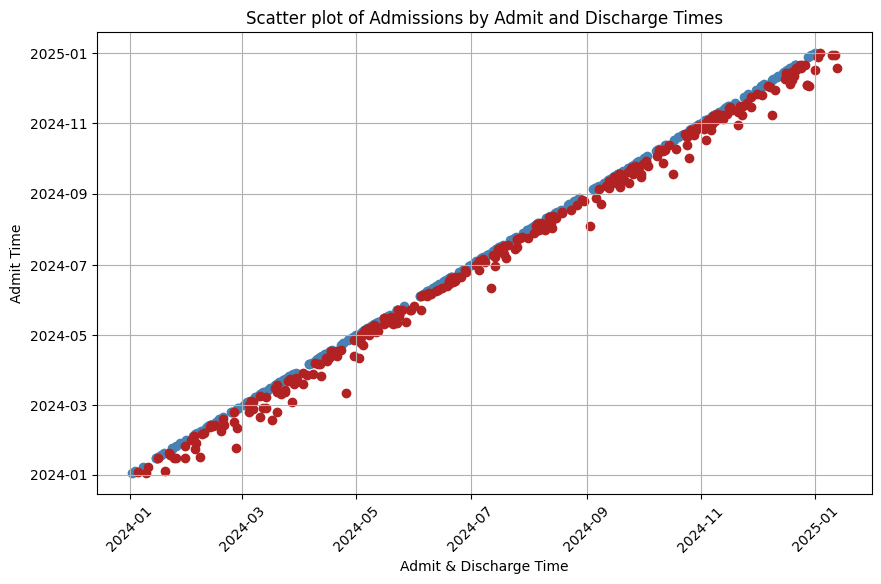

In [7]:
# Visualize admit and discharge time deltas for all patients
plt.figure(figsize=(10, 6))
plt.scatter(pd.to_datetime(df.loc[:, 'admittime']), df.loc[:, 'admittime'], color="steelblue")
plt.scatter(pd.to_datetime(df.loc[:, 'dischtime']), df.loc[:, 'admittime'], color="firebrick")

plt.xlabel('Admit & Discharge Time')
plt.ylabel('Admit Time')
plt.title('Scatter plot of Admissions by Admit and Discharge Times')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

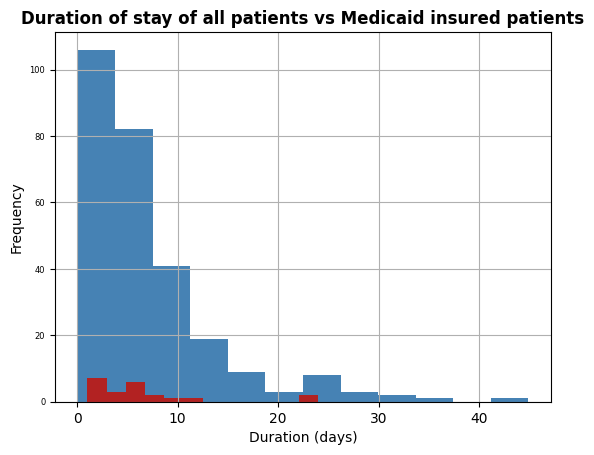

Non-Medicaid-insured patients: 6 days 22:22:08.537549407
Medicaid-insured patients: 6 days 10:52:10.909090909


In [8]:
# Medicaid patients are discharged, on average, slightly quicker than other patients
medicaid_df = df[df["insurance"] == "Medicaid"]
main_df = df[~df.index.isin(medicaid_df.index)]

ax = (df["duration_of_stay"].dt.total_seconds() / 86400).hist(bins=12, xlabelsize=10, ylabelsize=6, color="steelblue")
ax2 = (medicaid_df["duration_of_stay"].dt.total_seconds() / 86400).hist(bins=12, xlabelsize=10, ylabelsize=6, color="firebrick")
ax.set_title('Duration of stay of all patients vs Medicaid insured patients', weight='bold')
ax.set_xlabel('Duration (days)')
ax.set_ylabel('Frequency')
plt.show()

print(f"Non-Medicaid-insured patients: {main_df['duration_of_stay'].mean()}")
print(f"Medicaid-insured patients: {medicaid_df['duration_of_stay'].mean()}")

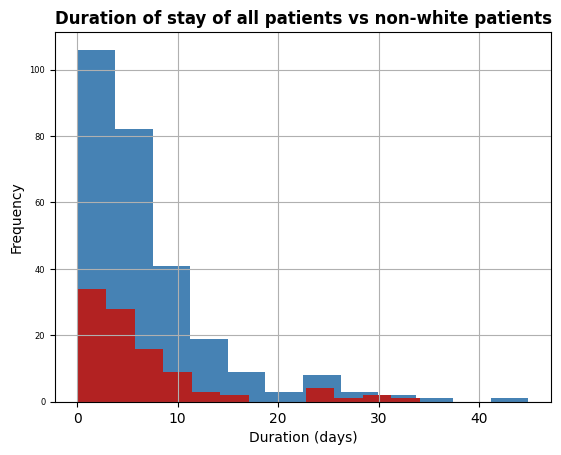

White patients: 7 days 01:40:22.628571428
Non-white patients: 6 days 14:03:26.400000


In [9]:
# Non-white patients are discharged, on average, significantly quicker than white patients
non_white_df = df[~df["race"].str.contains("WHITE")]
main_df = df[~df.index.isin(non_white_df.index)]

ax = (df["duration_of_stay"].dt.total_seconds() / 86400).hist(bins=12, xlabelsize=10, ylabelsize=6, color="steelblue")
ax2 = (non_white_df["duration_of_stay"].dt.total_seconds() / 86400).hist(bins=12, xlabelsize=10, ylabelsize=6, color="firebrick")
ax.set_title('Duration of stay of all patients vs non-white patients', weight='bold')
ax.set_xlabel('Duration (days)')
ax.set_ylabel('Frequency')
plt.show()

print(f"White patients: {main_df['duration_of_stay'].mean()}")
print(f"Non-white patients: {non_white_df['duration_of_stay'].mean()}")

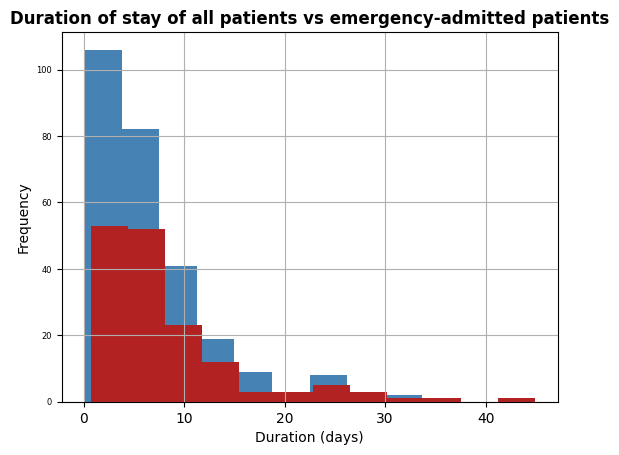

Otherwise-admitted patients: 5 days 06:00:32.542372881
Emergency-admitted patients: 8 days 03:05:30.955414012


In [10]:
# Patients admitted under emergency conditions are in hospital for significantly longer than other patients
emergency_df = df[(df["admission_type"].str.contains("EMER")) | (df["admission_type"].str.contains("URGENT"))]
main_df = df[~df.index.isin(emergency_df.index)]

ax = (df["duration_of_stay"].dt.total_seconds() / 86400).hist(bins=12, xlabelsize=10, ylabelsize=6, color="steelblue")
ax2 = (emergency_df["duration_of_stay"].dt.total_seconds() / 86400).hist(bins=12, xlabelsize=10, ylabelsize=6, color="firebrick")
ax.set_title('Duration of stay of all patients vs emergency-admitted patients', weight='bold')
ax.set_xlabel('Duration (days)')
ax.set_ylabel('Frequency')
plt.show()

print(f"Otherwise-admitted patients: {main_df['duration_of_stay'].mean()}")
print(f"Emergency-admitted patients: {emergency_df['duration_of_stay'].mean()}")

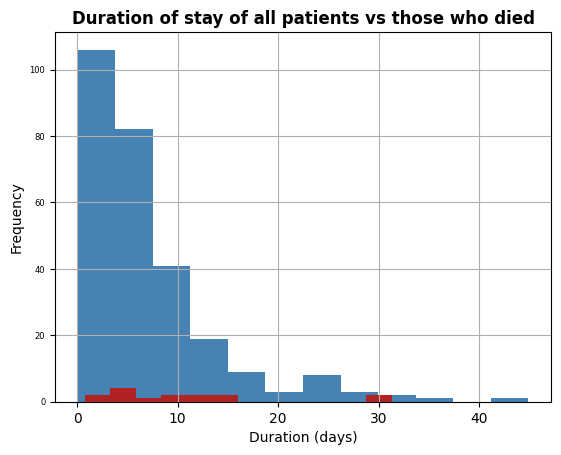

Patients who survived: 6 days 15:52:50.538461538
Patients who didn't: 10 days 21:58:04


In [11]:
# Patients who die in hospital do so after much-longer-than-average stays
dead_df = df[~df["deathtime"].isna()]
main_df = df[~df.index.isin(dead_df.index)]

ax = (df["duration_of_stay"].dt.total_seconds() / 86400).hist(bins=12, xlabelsize=10, ylabelsize=6, color="steelblue")
ax2 = (dead_df["duration_of_stay"].dt.total_seconds() / 86400).hist(bins=12, xlabelsize=10, ylabelsize=6, color="firebrick")
ax.set_title('Duration of stay of all patients vs those who died', weight='bold')
ax.set_xlabel('Duration (days)')
ax.set_ylabel('Frequency')
plt.show()

print(f"Patients who survived: {main_df['duration_of_stay'].mean()}")
print(f"Patients who didn't: {dead_df['duration_of_stay'].mean()}")

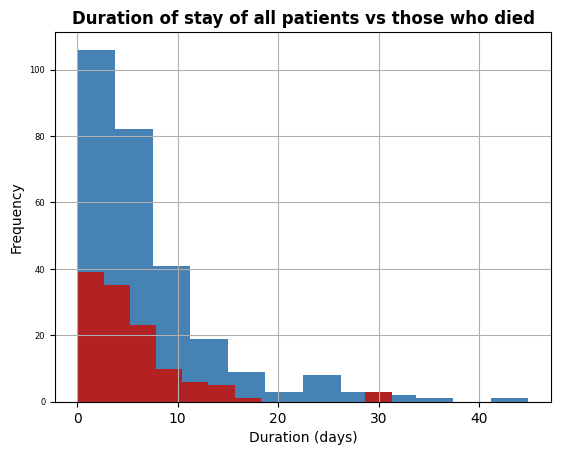

Patients admitted outside summer: 8 days 00:13:53.333333333
Patients admitted during summer: 5 days 11:51:40.819672131


In [12]:
# There is seasonality to stay duration: patients admitted in the summer months are discharged much quicker
summer_df = df[(df["admittime"].dt.month >= 5) & (df['admittime'].dt.month <= 9)]
main_df = df[~df.index.isin(summer_df.index)]

ax = (df["duration_of_stay"].dt.total_seconds() / 86400).hist(bins=12, xlabelsize=10, ylabelsize=6, color="steelblue")
ax2 = (summer_df["duration_of_stay"].dt.total_seconds() / 86400).hist(bins=12, xlabelsize=10, ylabelsize=6, color="firebrick")
ax.set_title('Duration of stay of all patients vs those who died', weight='bold')
ax.set_xlabel('Duration (days)')
ax.set_ylabel('Frequency')
plt.show()

print(f"Patients admitted outside summer: {main_df['duration_of_stay'].mean()}")
print(f"Patients admitted during summer: {summer_df['duration_of_stay'].mean()}")

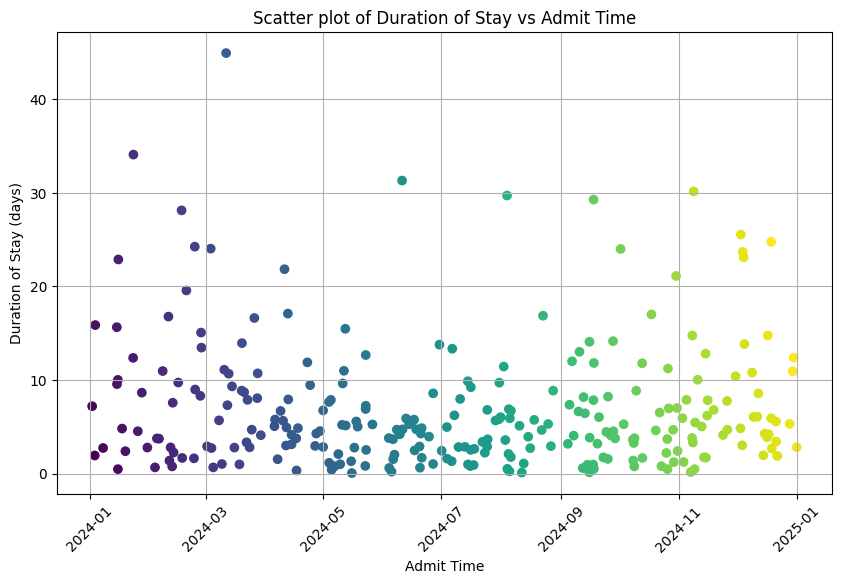

In [20]:
# Visualize admit and discharge time deltas for all patients
plt.figure(figsize=(10, 6))
plt.scatter(pd.to_datetime(df["admittime"]), (df["duration_of_stay"].dt.total_seconds() / 86400), c=df["dischtime"])

plt.xlabel('Admit Time')
plt.ylabel('Duration of Stay (days)')
plt.title('Scatter plot of Duration of Stay vs Admit Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()